## Scaling a network

I have a method that converts a portion of the conventional generator fleet in a Matpower network into wind generation. I need to modify this method so I can ultimately characterize algorithm performance versus number of decision variables.



In [1]:
# single proc
include("../src/TemporalInstanton.jl")
using TemporalInstanton

In [5]:
Profile.clear()

In [1]:
# two worker procs
addprocs(2)
@everywhere include("../src/TemporalInstanton.jl")
@everywhere using TemporalInstanton

In [2]:
inputData = load_rts96_data(return_as_type=true)

# Thermal model parameters:
inputData.Tamb = 35.0 # C
inputData.T0 = 60.0 #46.0 # initial line steady-state temp

inputData.time_values = 0.0:30.0:300.0 # five minutes in 30-sec steps
inputData.int_length = 300. # seconds = 5 min

Gp,Dp,Rp = inputData.G0,inputData.D0,inputData.R0
inputData.G0 = [0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp]
inputData.D0 = [0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp]
inputData.R0 = [Rp;1.1*Rp;1.2*Rp;1.3*Rp;1.4*Rp;1.5*Rp]

@time results = solve_temporal_instanton(inputData);
# @profile solve_temporal_instanton(inputData);
n = 73
nr = 18
T = 6
score,x,θ,α,diffs,xopt = process_instanton_results(results,
    n,
    nr,
    T);

 10.597880 seconds (2.67 M allocations: 147.737 MB, 0.31% gc time)


In [6]:
@time results = solve_temporal_instanton(inputData);

  1.297331 seconds (18.74 k allocations: 2.139 MB, 0.95% gc time)


In [4]:
sort(score)

104-element Array{Float64,1}:
    0.263788
    0.327316
    1.28861 
    2.20415 
    2.32297 
    2.42316 
    4.67876 
    4.86524 
    4.89917 
    5.67827 
    5.93862 
    6.43917 
    6.46089 
    ⋮       
  178.086   
  303.003   
  370.614   
  370.614   
  391.307   
  428.944   
  923.98    
  979.199   
 1319.85    
 1390.03    
 1967.27    
 1967.27    

## Convert subset of conventional generation in mpc to wind generation

In [190]:
using MatpowerCases, HDF5, JLD

""" 20150-09-06. Modified version of mat2tmpinst.
Load (and generate) everything needed to perform temporal 
instanton analysis for any network supported by MatpowerCases.

* `num_wind_farms`: how many wind farms do you want?
* `wind_penetration`: desired value of sum(G0)/sum(R0)

Note: each wind farm's output is sum(Gp)*wind_penetration/num_wind_farms
"""
function mat2tmpinst(
    name::ASCIIString,
    num_wind_farms::Int64,
    wind_penetration::Float64;
    return_as_type::Bool = true
    )
    mpc = loadcase(name,describe=false)
    
    bus_orig = mpc["bus"][:,1]
    bus_simple = collect(1:length(bus_orig))
    
    genBus = mpc["gen"][:,1]
    for i in bus_simple
        genBus[genBus.==bus_orig[i]] = bus_simple[i]
    end
    
    try
        Sb = mpc["baseMVA"]
    catch
        warn("Base MVA missing from mpc data.")
        Sb = 100.0
    end
    Gp_long = mpc["gen"][:,2]

    f = round(Int64,mpc["branch"][:,1]) # "from bus" ...
    t = round(Int64,mpc["branch"][:,2]) # ... "to bus"
    for i in bus_simple
        f[f.==bus_orig[i]] = bus_simple[i]
        t[t.==bus_orig[i]] = bus_simple[i]
    end    
    r = mpc["branch"][:,3]              # resistance, pu
    x = mpc["branch"][:,4]              # reactance, pu
    b = mpc["branch"][:,5]              # susceptance, pu

    Y = createY(f,t,x)

    Gp = zeros(length(bus_simple))
    for i in bus_simple
        Gp[convert(Int64,i)] = sum(Gp_long[find(genBus.==i)])/Sb
    end

    Dp = mpc["bus"][:,3]./Sb
    
    # convert generators into wind farms:
    windsize = sum(Gp)*wind_penetration/num_wind_farms
#     Ridx = rand(1:length(Gp),num_wind_farms)
    Ridx = sortperm(Gp + Dp)[1:num_wind_farms]
    
    Rp = zeros(length(Gp))
    Rp[Ridx] = windsize

    Sb = Sb*1e6 # convert from MW to W

    ref = 1

    lines = [(f[i],t[i]) for i in 1:length(f)]
    lines = convert(Array{Tuple{Int64,Int64},1},lines)

#     res = r
#     reac = x

    # Allow each generator to participate equally in droop response.
    k = Float64[]
    for i = 1:length(Gp)
        if Gp[i] != 0
            push!(k, 1/length(find(Gp)))
        else
            push!(k,0)
        end
    end

    # use RTS-96 line lengths to generate similar line lengths
    line_lengths = load("../data/polish_line_lengths.jld","line_lengths")[1:length(lines)]

    # temporary (re-use rts-96 line conductor parameters)
    line_conductors = fill("waxwing",length(line_lengths))
    if return_as_type
        return InstantonInputData(Ridx,Y,Gp,Dp,Rp,Sb,ref,lines,r,x,k,line_lengths,line_conductors,
        NaN,NaN,NaN,0.0:0.0,Array{Float64,2}())
    else
        return Ridx,Y,Gp,Dp,Rp,Sb,ref,lines,r,x,k,line_lengths,line_conductors
    end
end

mat2tmpinst (generic function with 3 methods)

In [191]:
time_alloc = Array{Tuple{Float64,Int64},1}()
for num_wind_farms = 1:20
    d = mat2tmpinst("case118",10,0.70)

    # Thermal model parameters:
    d.Tamb = 35.0 # C
    d.T0 = 60.0 #46.0 # initial line steady-state temp

    d.time_values = 0.0:30.0:300.0 # five minutes in 30-sec steps
    d.int_length = 300. # seconds = 5 min

    Gp,Dp,Rp = d.G0,d.D0,d.R0
    d.G0 = [0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp]
    d.D0 = [Dp;Dp;Dp;Dp;Dp;Dp]
    d.R0 = [Rp;1.1*Rp;1.2*Rp;1.3*Rp;1.4*Rp;1.5*Rp]
    data = @timed solve_temporal_instanton(d)
    push!(time_alloc,(data[2],data[3]))
end

In [192]:
time_alloc

20-element Array{Tuple{Float64,Int64},1}:
 (4.101871505,2466952292)
 (4.066097554,2466952052)
 (4.571989358,2466952052)
 (4.574045049,2466952052)
 (4.568353924,2466952052)
 (5.000656257,2466952052)
 (5.076772502,2466952052)
 (5.087504747,2466952052)
 (4.822073522,2466952052)
 (4.94071637,2466952052) 
 (5.10915601,2466952052) 
 (5.090802126,2466952052)
 (6.440356724,2466952052)
 (5.130750712,2466952052)
 (5.142513282,2466952052)
 (5.222927112,2466952052)
 (5.240216235,2466952052)
 (5.147294059,2466952052)
 (5.161454776,2466952052)
 (5.182812158,2466952052)

In [170]:
using PyPlot
PyPlot.svg(true)

true

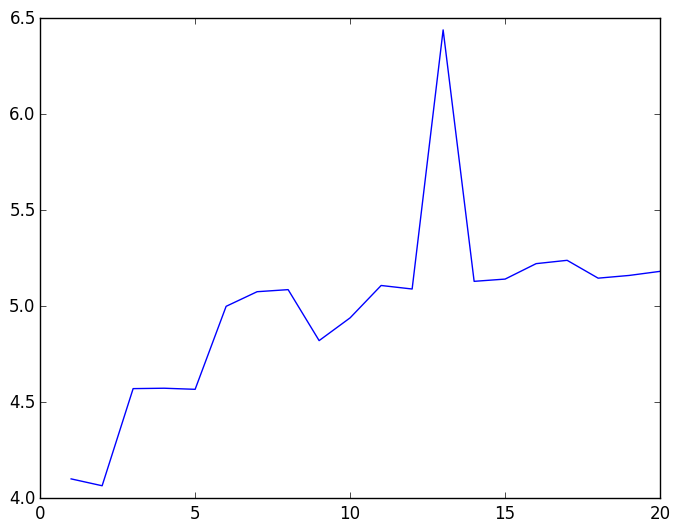

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f7a99dc5c18>

In [193]:
time_vals = [time_alloc[i][1] for i in 1:length(time_alloc)]
alloc_vals = [time_alloc[i][2] for i in 1:length(time_alloc)]

plot(1:20,time_vals)

## Characterizing problem size

How exactly does temporal instanton analysis scale with network characteristics?

For each time step, there are $N_R$ wind forecast error variables $dev$, $N-1$ independent bus angle variables $\theta$, one power mismatch variable $\alpha$, and one auxiliary variable used in the line temperature constraint (and defined in terms of angles at the endpoints of the chosen transmission line). Thus, there are $(N_R + N + 2)\cdot T$ variables in each QCQP.

For each time step, there are $N-1$ power balance constraints, one generator droop response constraint, and one constraint relating line endpoint angle variables to an auxiliary heat balance variable. Thus, there are $(N+2)\cdot T$ linear constraints in each QCQP.

The most expensive operations in the QCQP solution method are 

In [194]:
Profile.clear()

In [ ]:
@profile outputData = solve_temporal_instanton(inputData);